# 04_mers_tweets_analysis
As an addendum to the analysis conducted on overall tweets in the context of the world cup, we also identified the emergence of conversation regarding 'MERS', a new and unusual virus/illness. We took the chance to collect all tweets referencing MERS, for one week, from `10/12/2022` to `17/12/2022`. We are fairly confident that these represent *all* tweets in this time period referencing our target search terms. 

In this notebook, we perform similar analysis on these tweets to that we performed on the core World Cup twitter data. 

This means in practice:
- Sentiment of tweets relating to MERS, top relevant keywords
- Which users tweeted most MERS-related content in the timeframe in question? 
- Which particular tweets were the most popular pieces of content in this collection?
- What were the top URLs and domains? 
- Exporting all these league tables as csvs.

NL, 13/01/23

### IMPORTS

In [111]:
import os
import json
import pandas as pd
import numpy as np
import re
from collections import Counter


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns

### PATHS & CONSTANTS

In [2]:
TWEETS_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/mers_tweets/'
SEARCH_TERMS = '/home/nikloynes/projects/world_cup_misinfo_tracking/data_collection/mers_search_terms.txt'
EXPORT_PATH = '/home/nikloynes/projects/world_cup_misinfo_tracking/data/exports/mers_tweets/'


### FUNCTIONS

In [66]:
def remove_pattern(input, pattern):
    out = re.sub(pattern, '', input)
    return out

def clean_tweets(tweets):
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:")
    tweets = np.vectorize(remove_pattern)(tweets, "rt @[\w]*:")
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    return tweets

In [67]:
lemmatizer = WordNetLemmatizer()

def remove_stopwords(text:list):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

def word_lemmatizer(text:list):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

### INIT

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

In [69]:
sentiment_analyser = SentimentIntensityAnalyzer()

### THE THING!

Let's start by reading in our tweets, and creating dataframes for all the stuff we want to look into specifically.

In [7]:
tweet_files = os.listdir(TWEETS_PATH)
del tweet_files[6] # removing reference to the incorporated `meta` directory

In [9]:
tweet_files.sort()

In [11]:
tweet_files = [TWEETS_PATH+x for x in tweet_files]

In [39]:
all_tweets = []
all_urls_timestamps = []

for file in tweet_files:
    with open(file, 'r') as infile:
        for line in infile:
            tmp = json.loads(line)
            if 'domains' in tmp.keys():
                del tmp['domains']
            if 'entities' in tmp.keys():
                del tmp['entities']
            all_tweets.append(tmp)

            if 'urls' in tmp.keys():
                for item in tmp['urls']:
                    all_urls_timestamps.append({'url' : item, 'timestamp' : tmp['created_at']})

In [40]:
len(all_tweets)

58514

We have collected a total of `58,514` tweets over the course of this 7-day window.

In [153]:
all_tweets_df = pd.DataFrame(all_tweets)

In [154]:
all_tweets_df = all_tweets_df.rename(columns={'id' : 'tweet_id'})

In [155]:
all_tweets_df = pd.concat([all_tweets_df.drop(['public_metrics'], axis=1), all_tweets_df['public_metrics'].apply(pd.Series)], axis=1)

In [156]:
all_tweets_df = pd.concat([all_tweets_df.drop(['user'], axis=1), all_tweets_df['user'].apply(pd.Series)], axis=1)

In [157]:
all_tweets_df = all_tweets_df.rename(columns={'id' : 'user_id'})

In [158]:
all_tweets_df = pd.concat([all_tweets_df.drop(['public_metrics'], axis=1), all_tweets_df['public_metrics'].apply(pd.Series)], axis=1)

In [159]:
all_tweets_df = all_tweets_df.rename(columns = {all_tweets_df.columns[1] : 'tweet_created_at', all_tweets_df.columns[11] : 'user_created_at'})    

OK, we've built our tweet overview dataframe. Seeing as we're not dealing with that many tweets here, it's totally fine to analyse everything in one go (rather than reading in and analysing tweets sequentially, line by line)

This is what it looks like:

In [160]:
all_tweets_df.head()

,author_id,user_created_at,tweet_id,referenced_tweets,source,text,urls,retweet_count,reply_count,like_count,quote_count,user_created_at,description,user_id,location,name,username,followers_count,following_count,tweet_count,listed_count
0,4833662554,2022-12-11T17:59:57.000Z,1602000248280616961,"[{'type': 'retweeted', 'id': '1601941237975621...",Twitter Web App,RT @RealGeorgeWebb1: I admit waiting for the Z...,NaN,119,0,0,0,2016-01-21T23:42:21.000Z,Master's Degree in Business Administration and...,4833662554,"Münster, Germany",Sebastian Marius Christ,KreuzundQuerHan,94,650,3368,2
1,93248021,2022-12-11T17:58:10.000Z,1601999799254917126,"[{'type': 'retweeted', 'id': '1601896881956671...",Twitter Web App,RT @RealGeorgeWebb1: Did A MERS-2 Smoking Gun ...,[https://t.co/EkII1suxNf],69,0,0,0,2009-11-28T19:54:04.000Z,Proud Husband Father Grandfather Business Owne...,93248021,Northern Illinois,Paul Engelbrecht,1PaulPatriot,100,297,4358,1
2,516696943,2022-12-11T17:58:06.000Z,1601999782381162496,"[{'type': 'retweeted', 'id': '1601941237975621...",Twitter Web App,RT @RealGeorgeWebb1: I admit waiting for the Z...,NaN,119,0,0,0,2012-03-06T17:18:14.000Z,Innovative advanced reactive mobile applicatio...,516696943,India,Advanced Apps,WebprogrPRO,1521,4998,63348,499
3,196683454,2022-12-11T17:57:20.000Z,1601999589925478400,NaN,twittbot.net,【今日の暗記シリーズ】\nQ:2類感染症をあげよ。\n\nA:ポリオ(急性灰白髄炎)、ジフテ...,NaN,0,0,0,0,2010-09-29T17:34:46.000Z,毎日、国試に関わる言葉を残していきます。なんとなくTwitterを見ている時に目にして勉強す...,196683454,東京都台東区,毎日柔整国試対策一言配信@フラスター塾,pf_jyuku,1476,149,42189,20
4,1283825574788489217,2022-12-11T17:55:17.000Z,1601999072038387712,"[{'type': 'replied_to', 'id': '160170284282560...",Twitter for Android,@beansprouts_mom Also cause they are calling i...,NaN,0,1,3,0,2020-07-16T18:08:04.000Z,"Into abandoned buildings, Paranormal, and casinos",1283825574788489217,"Anchorage, AK",Eliza,Eliza13697364,123,290,8337,1


We've also extracted all URLs from our tweets, let's reduce these to unique URLs so we can expand them.

In [52]:
all_urls_timestamps_df = pd.DataFrame(all_urls_timestamps)
len(all_urls_timestamps_df)

13839

A total of `13,839` URLs. 

In [61]:
unique_urls_freqs_df = all_urls_timestamps_df.groupby('url').count().reset_index().rename(columns={'timestamp' : 'freq'}).sort_values('freq', ascending=False).reset_index(drop=True)

In [62]:
unique_urls_freqs_df.head()

,url,freq
0,https://t.co/i7IPLaxIGT,1463
1,https://t.co/oUSMocepHI,691
2,https://t.co/kpJ1m2CjKG,347
3,https://t.co/tmpTKmocXw,219
4,https://t.co,117


In [63]:
len(unique_urls_freqs_df)

7037

We have a total of `7,037` unique URLs. A manageable amount, which we will now export for outsorced expansion.

In [64]:
unique_urls_freqs_df.to_csv(EXPORT_PATH+'unique_urls_freqs.csv', index=False)

In the meantime, let's do some more processing and analysis on our data.

#### 1. Sentiment classification

For this particular application, sentiment analysis seems like a useful tool. Let's run it on these tweets and see what we find.

In [78]:
clean_text = list(all_tweets_df['text'])

In [79]:
clean_text = [tweet.lower() for tweet in clean_text]

In [80]:
clean_text = clean_tweets(clean_text)

In [82]:
clean_text = remove_stopwords(clean_text)

In [86]:
clean_text = np.vectorize(remove_pattern)(clean_text, "\n")

In [88]:
clean_text = np.vectorize(remove_pattern)(clean_text, "rt : ")

run the sentiment classification

In [90]:
scores = []

for tweet in clean_text:
    tmp = sentiment_analyser.polarity_scores(tweet)
    scores.append(tmp)

merging back into the overall tweet dataset

In [161]:
all_tweets_df = pd.concat([all_tweets_df, pd.DataFrame(scores)], axis=1)

A basic histogram of the distribution of our `compound` score

<AxesSubplot: >

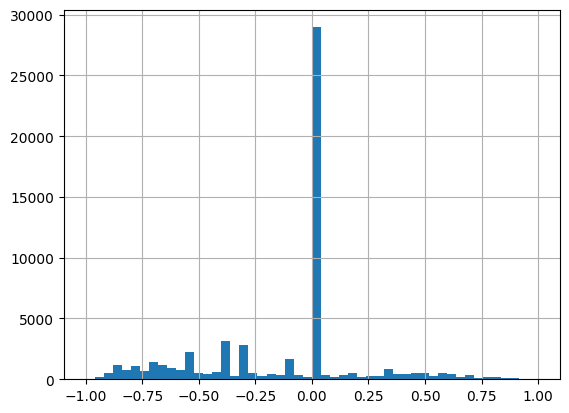

In [162]:
all_tweets_df['compound'].hist(bins=50)

And a more fluid density plot

<AxesSubplot: xlabel='compound', ylabel='Density'>

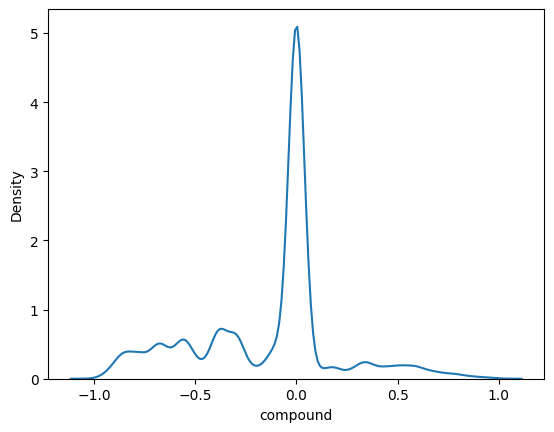

In [163]:
sns.kdeplot(data=all_tweets_df, x='compound')

OK -- the sentiment algorithm isn't performing brilliantly -- most of the tweets are still being classified as neutral. 

But - especially in the smoothed kernel plot, we can tell that there are more tweets classified as negative than positive. 

We will now produce our most frequent words for negative and positive tweets.

In [107]:
scores[1]

{'neg': 0.542, 'neu': 0.458, 'pos': 0.0, 'compound': -0.7964}

In [108]:
pos_words = []
neg_words = []

for i,tweet in enumerate(clean_text):
    if scores[i]['compound']>0:
        pos_words += tweet.split()
    if scores[i]['compound']<0:
        neg_words += tweet.split()

In [115]:
pos_words = remove_stopwords(pos_words)
neg_words = remove_stopwords(neg_words)

In [116]:
pos_words_counts = dict(zip(Counter(pos_words).keys(), Counter(pos_words).values()))
pos_words_counts = dict(sorted(pos_words_counts.items(), key=lambda x:x[1], reverse=True))

In [117]:
neg_words_counts = dict(zip(Counter(neg_words).keys(), Counter(neg_words).values()))
neg_words_counts = dict(sorted(neg_words_counts.items(), key=lambda x:x[1], reverse=True))

In [124]:
pos_words_counts_df = pd.DataFrame.from_dict(pos_words_counts.items()).reset_index(drop=True)
pos_words_counts_df = pos_words_counts_df.rename(columns={0 : 'word', 1 : 'freq'})

neg_words_counts_df = pd.DataFrame.from_dict(neg_words_counts.items()).reset_index(drop=True)
neg_words_counts_df = neg_words_counts_df.rename(columns={0 : 'word', 1 : 'freq'})

In [125]:
pos_words_counts_df[:50]

,word,freq
0,mers,4400
1,like,1668
2,de,1276
3,pandemic,1053
4,world,927
5,would,916
6,la,889
7,covid,857
8,ha,706
9,look,610


In [126]:
neg_words_counts_df[:50]

,word,freq
0,mers,8792
1,world,5060
2,camel,3352
3,cup,3032
4,flu,2817
5,"""camel",2808
6,"mers,",2622
7,qatar,2549
8,+,2393
9,coronavirus,2127


#### 2. Users

In [164]:
all_users_df = all_tweets_df.groupby('author_id').count()[['text']].reset_index().merge(all_tweets_df.groupby('author_id').sum()[['retweet_count', 'reply_count', 'like_count', 'quote_count']].reset_index(), on='author_id', how='left')

/tmp/ipykernel_366615/1048200131.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_users_df = all_tweets_df.groupby('author_id').count()[['text']].reset_index().merge(all_tweets_df.groupby('author_id').sum()[['retweet_count', 'reply_count', 'like_count', 'quote_count']].reset_index(), on='author_id', how='left')


In [165]:
all_users_df = all_users_df.rename(columns={'text' : 'n_tweets'})

In [166]:
all_users_df = all_users_df.sort_values('n_tweets', ascending=False).reset_index(drop=True)

In [167]:
all_users_df = all_users_df.rename(columns={'author_id' : 'user_id'})

merge in user metadata

In [171]:
all_users_df = all_users_df.merge(all_tweets_df[['user_id', 'username', 'name', 'location', 'followers_count', 'following_count', 'tweet_count', 'listed_count']], 
                                  on='user_id',
                                  how='left')

In [175]:
all_users_df = all_users_df.drop_duplicates('user_id').reset_index(drop=True)

**League Tables**

A: Most tweets in our sample

In [176]:
all_users_df[:100]

,user_id,n_tweets,retweet_count,reply_count,like_count,quote_count,username,name,location,followers_count,following_count,tweet_count,listed_count
0,17298589,86,11354,0,0,0,mariacate,mariacate,NaN,353,151,29688,0
1,863572378324017158,85,9877,32,362,3,nailatrahman,Naila T Rahman নায়লা তাসনীম,NaN,1587,2198,122507,19
2,1216827461280980992,63,4,38,90,0,residentJihadi,Friendly Jihadi,Canada,308,1665,22384,0
3,1379538284045508609,61,403,85,548,18,realConnieBevan,Connie Bevan,NaN,1688,68,11442,13
4,1498028287439908868,61,4,17,57,0,ToroMercado1910,🇦🇷PERRONEGRO🇺🇦,Rosario Santa Fe Argentina,90,673,6982,3
5,26973844,61,12684,8,96,0,ampincivero,Ann Marie Pincivero 🌻🇺🇦💙,Canada,11044,10559,174181,120
6,987844879,58,7627,0,1,0,bprophetable,💧Bprophetable ⧖,active locally globally,4089,5001,515852,310
7,796209435865661440,56,18110,0,0,0,inforenique,My InfoRenique,Germany,969,3082,613681,11
8,1353948213527638016,54,1903,12,107,7,danishdibiasky,☄ Anders Hedegård Sørensen ☄,NaN,157,102,7256,3
9,53752278,47,13869,0,3,0,srk908,Sandy Karasik 🇺🇸 🇺🇦 🌻,Philadelphia,1855,3934,292785,4


Most RT-d in our sample

In [181]:
all_users_df.sort_values('retweet_count', ascending=False)[:100].reset_index(drop=True)

,user_id,n_tweets,retweet_count,reply_count,like_count,quote_count,username,name,location,followers_count,following_count,tweet_count,listed_count
0,796209435865661440,56,18110,0,0,0,inforenique,My InfoRenique,Germany,969,3082,613681,11
1,53752278,47,13869,0,3,0,srk908,Sandy Karasik 🇺🇸 🇺🇦 🌻,Philadelphia,1855,3934,292785,4
2,2397276883,28,12853,0,0,0,Bastgoddess7,❄️HO❄️ HO❄️ HO❄️ERA (PaRoDy™️),"Boston, Ma",2198,5004,157761,68
3,26973844,61,12684,8,96,0,ampincivero,Ann Marie Pincivero 🌻🇺🇦💙,Canada,11044,10559,174181,120
4,2896471770,22,12363,0,0,0,ValveIII,hello,NaN,32,381,16771,0
5,988601164785635330,25,11898,0,0,0,sqirlgirly,sqirlgirly@mstdn.ca Sqirlgirly@counter.social,"Regina, Saskatchewan",1212,2158,265499,0
6,17298589,86,11354,0,0,0,mariacate,mariacate,NaN,353,151,29688,0
7,706209304378896384,43,11271,0,4,0,teambernie27001,Former Bernie Supporter for #ZeroCovid,"Maryland, USA",6125,6763,229276,79
8,2485308468,21,10909,0,0,0,RaniLyons,FreakQueen,#nofixedaddress,5104,4956,564436,708
9,1409116811207970819,33,10665,0,0,0,THpY72PN3PHJCH3,出雲優生 『深淵が覗く時ーコロナ禍の介護日誌』好評発売中,NaN,189,34,44649,5


Most liked in our sample

In [182]:
all_users_df.sort_values('like_count', ascending=False)[:100].reset_index(drop=True)

,user_id,n_tweets,retweet_count,reply_count,like_count,quote_count,username,name,location,followers_count,following_count,tweet_count,listed_count
0,151257881,7,3522,246,16482,181,TRyanGregory,T. Ryan Gregory,"Ontario, Canada",56625,4022,42457,795
1,1172849521082208256,5,1966,268,10547,242,VandomVA,Alexis Vandom 🏳️‍⚧️,"Vancouver, WA",1121,848,14326,7
2,960817018193764352,27,1161,260,10178,83,1goodtern,tern,"Oxford, England",31367,4584,57176,289
3,316273207,6,2825,443,9374,322,doctormacias,Alejandro Macias,"Leon, Mexico",403840,238,35032,1186
4,17306975,2,1955,154,8069,445,livedoornews,ライブドアニュース,NaN,1607178,99,343320,11278
5,76614123,18,2637,13,5222,119,dai_jiro,䑓 次郎,Tokyo,5508,1106,49737,133
6,106722362,1,1153,170,4370,189,AmmahStarr,"Stella Safo, MD MPH","Brooklyn, NY",22291,4332,21671,190
7,1165037193037062144,6,683,49,4102,33,DecorumManager,Decorum Disassembly - mas.to/@decorummanager,NaN,2125,1377,8007,17
8,514564994,2,1942,175,3978,52,MarkDStrauss,Mark Strauss,Sol III,7012,5304,15790,154
9,1193721035490807808,3,817,59,3603,19,DrPacoMoreno1,Dr Francisco Moreno Sánchez,NaN,217204,201,1891,568


Most followers

In [184]:
all_users_df.sort_values('followers_count', ascending=False)[:100].reset_index(drop=True)

,user_id,n_tweets,retweet_count,reply_count,like_count,quote_count,username,name,location,followers_count,following_count,tweet_count,listed_count
0,37034483,1,2,0,0,0,ndtv,NDTV,India,17631036,15,1056870,14496
1,55507370,1,0,0,2,0,tvOneNews,tvOnenews,Pulo Gadung,9759325,50,354429,8696
2,36327407,1,0,0,7,1,htTweets,Hindustan Times,India,8676878,129,1170064,8387
3,19897138,1,5,1,13,1,IndiaToday,IndiaToday,India,6223392,114,1105265,6749
4,39743812,2,3,0,18,0,EconomicTimes,Economic Times,NaN,4307999,45,633970,9297
5,68440549,1,20,0,35,1,libe,Libération,"Paris, France",3484418,297,275382,17210
6,50626996,1,15,1,31,3,UNAM_MX,UNAM,Mexico,3406606,620,95030,4535
7,69416519,1,9,8,10,4,infobae,infobae,NaN,3363733,0,960397,9304
8,98362607,2,3,0,24,1,News18India,News18 India,India,3060890,92,451853,1820
9,15438913,1,51,72,65,56,MailOnline,Daily Mail Online,NaN,2803542,2208,487077,13877


I will export the `all_users_df` dataframe, you can then sort on the specific columns to replicate the data displayed above.

#### 3. Tweets

Let's now have a look at tweets. What were the most popular tweets in our collection? 

A: Most liked

In [192]:
all_tweets_df.sort_values('like_count', ascending=False).reset_index(drop=True)[:100]

,author_id,user_created_at,tweet_id,referenced_tweets,source,text,urls,retweet_count,reply_count,like_count,quote_count,user_created_at,description,user_id,location,name,username,followers_count,following_count,tweet_count,listed_count,neg,neu,pos,compound
0,17306975,2022-12-17T00:06:01.000Z,1603904312970997760,NaN,Twitter Web App,【W杯】フランス代表、複数選手が正体不明のウイルスで体調不良\nhttps://t.co/i...,"[https://t.co/i7IPLaxIGT, https://t.co/7nYEPta...",1914,152,7983,437,2008-11-11T09:56:31.000Z,国内・海外のニュースや芸能情報、ネットで話題の小ネタまで、幅広いジャンルのニュースをいち早く...,17306975,NaN,ライブドアニュース,livedoornews,1607179,99,343320,11278,0.000,1.000,0.000,0.0000
1,151257881,2022-12-12T18:56:01.000Z,1602376744660500490,NaN,Twitter for Android,"""Camel flu"" is not flu. It's MERS, a coronavir...",NaN,1533,106,6983,92,2010-06-03T00:32:51.000Z,Professor of evolutionary biology. Monger (fea...,151257881,"Ontario, Canada",T. Ryan Gregory,TRyanGregory,56625,4022,42457,795,0.155,0.715,0.130,-0.1068
2,316273207,2022-12-16T18:40:14.000Z,1603822323840204801,NaN,Twitter for iPhone,Al parecer un virus afecta a varios jugadores ...,NaN,1273,353,6886,296,2011-06-13T06:06:02.000Z,Medical doctor. Former 2009 Pandemic Influenza...,316273207,"Leon, Mexico",Alejandro Macias,doctormacias,403840,238,35032,1186,0.000,1.000,0.000,0.0000
3,1172849521082208256,2022-12-12T05:57:56.000Z,1602180935533072385,NaN,Twitter for Android,Two journalists have died while covering the W...,NaN,1379,177,6480,203,2019-09-14T12:28:20.000Z,#RemoteCapable Voice Actress | Omni Polyam Tra...,1172849521082208256,"Vancouver, WA",Alexis Vandom 🏳️‍⚧️,VandomVA,1121,848,14326,7,0.071,0.929,0.000,-0.5574
4,151257881,2022-12-13T12:38:58.000Z,1602644244992299010,NaN,Twitter for Android,A few things about MERS:\n\n* Media are callin...,NaN,1359,107,6309,75,2010-06-03T00:32:51.000Z,Professor of evolutionary biology. Monger (fea...,151257881,"Ontario, Canada",T. Ryan Gregory,TRyanGregory,56625,4022,42457,795,0.198,0.692,0.111,-0.5267
5,76614123,2022-12-18T00:38:42.000Z,1604274923459182593,NaN,Twitter for iPhone,MERS再来か、MERS-2かと想像されるウイルスが、カタールでの国際サッカー大会と、開催周...,NaN,1799,10,4461,107,2009-09-23T10:52:30.000Z,出版社勤め。Covid-19の子どもたち、特に乳幼児の重症化や致死リスクの警告を続けます。L...,76614123,Tokyo,䑓 次郎,dai_jiro,5687,1109,49795,136,0.000,1.000,0.000,0.0000
6,106722362,2022-12-13T12:49:02.000Z,1602646779413073922,NaN,Twitter for iPhone,There are many reasons to be wearing a mask ri...,NaN,1153,170,4370,189,2010-01-20T14:02:50.000Z,"HIV primary care physician, NYC | Passionate a...",106722362,"Brooklyn, NY","Stella Safo, MD MPH",AmmahStarr,22291,4332,21671,190,0.077,0.923,0.000,-0.3818
7,514564994,2022-12-12T06:32:17.000Z,1602189577610985473,NaN,Twitter for iPad,"SARS, Monkey Pox, H5N2, Zika, MERS…I don’t thi...",NaN,1002,175,3978,52,2012-03-04T17:30:03.000Z,“Just a kid from Brooklyn.”,514564994,Sol III,Mark Strauss,MarkDStrauss,7012,5304,15790,154,0.080,0.864,0.057,-0.2500
8,1172849521082208256,2022-12-12T06:02:19.000Z,1602182039410970625,"[{'type': 'replied_to', 'id': '160218093553307...",Twitter for Android,"Well, I'll put it this way. A global MERS pand...",NaN,525,72,3759,32,2019-09-14T12:28:20.000Z,#RemoteCapable Voice Actress | Omni Polyam Tra...,1172849521082208256,"Vancouver, WA",Alexis Vandom 🏳️‍⚧️,VandomVA,1121,848,14326,7,0.155,0.754,0.091,-0.6369
9,1165037193037062144,2022-12-12T16:34:32.000Z,1602341139222257666,NaN,Twitter for iPhone,It took me a few minutes &amp; an entire cup o...,NaN,655,40,3611,31,2019-08-23T23:05:37.000Z,Cave Syndrome Understander - Still believes in...,1165037193037062144,NaN,Decorum Disassembly - mas.to/@decorummanager,DecorumManager,2125,1377,8007,17,0.103,0.897,0.000,-0.6696


B: Most retweeted

In [194]:
all_tweets_df.sort_values('retweet_count', ascending=False).reset_index(drop=True)[:100]

,author_id,user_created_at,tweet_id,referenced_tweets,source,text,urls,retweet_count,reply_count,like_count,quote_count,user_created_at,description,user_id,location,name,username,followers_count,following_count,tweet_count,listed_count,neg,neu,pos,compound
0,1430424458,2022-12-18T15:04:07.000Z,1604492713633542145,"[{'type': 'retweeted', 'id': '5866050649297182...",Twitter for Android,RT @CoranFR: «Il a donné libre cours aux deux ...,[http://t.],2849,0,0,0,2013-05-15T12:39:59.000Z,Cheikh | Domou Cheikh | Seutou Cheikh |Talibé ...,1430424458,Dakar,CheiDI 🌟🌟🌟🌟🌟🌟🌟,Hey_CheiDI,81,40,2160,0,0.000,1.000,0.0,0.0000
1,138862380,2022-12-17T22:11:58.000Z,1604237997238784000,"[{'type': 'retweeted', 'id': '1586432890665041...",Twitter for iPhone,"RT @esoryelsnya: What do AIDS, MERS, ZIKA, Bir...",NaN,2065,0,0,0,2010-04-30T20:50:52.000Z,Acupuncturist/Ex-SW-Trainer/Anti-Cap #Canadian...,138862380,"Palmer, Alaska",Samantha Berg,Sam10k,10452,8783,229511,311,0.167,0.833,0.0,-0.3818
2,1068041983090782208,2022-12-17T03:23:41.000Z,1603954053381124096,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter for iPhone,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2018-11-29T07:20:26.000Z,あけましておめでとう🇯🇵 表現の自由を侵害するな。 マスクをしてない対面の会話はお互いのウ...,1068041983090782208,NaN,🇯🇵黒飛,kurotobi2018,176,592,23822,5,0.000,1.000,0.0,0.0000
3,866447479339761665,2022-12-17T03:23:51.000Z,1603954098415357953,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter Web App,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2017-05-22T00:15:51.000Z,pso2でスカサハ、FF14では光のエロ侍として活動中。\nFF14はリディル鯖、テイルズ好...,866447479339761665,NaN,筋肉が好き（スカサハすっきやねん）,646d230dd52b4d5,324,1172,130180,8,0.000,1.000,0.0,0.0000
4,114253287,2022-12-17T03:24:40.000Z,1603954303739105286,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter for iPhone,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2010-02-14T18:30:50.000Z,スポーツと音楽とゲームの話題中心。プラモとかも作ります。野球は日本ハムファイターズ。特定の話...,114253287,沼,やつは(*YTH*し,8_leaf,335,681,225794,22,0.000,1.000,0.0,0.0000
5,1662021360,2022-12-17T03:25:04.000Z,1603954405128417280,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter for Android,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2013-08-11T08:49:52.000Z,20↑ / チ゛リ゛ち゛ゃ゛ん゛ｯｯｯ！！！！🐴娘…ゴルマクライステイオーウオッカ師匠...,1662021360,@ponkjcd_0903 → @ponsrus_0593,ぽ ん 🐴,ponsrus_0593,994,410,138646,46,0.000,1.000,0.0,0.0000
6,1912595406,2022-12-17T03:26:55.000Z,1603954869932785664,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter for iPhone,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2013-09-28T00:01:22.000Z,あむこふるしんにお熱すぎてアカウント作りました @yumiun5 /弓子です/rt魔注意/2...,1912595406,腐海,弓(うん)子,yumi_yumi_koko,358,559,176270,9,0.000,1.000,0.0,0.0000
7,804985754665373696,2022-12-17T03:26:59.000Z,1603954884855726080,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter for Android,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2016-12-03T09:48:54.000Z,20歳↑/アイコンはpicrewの少年少女好き？で作成した物です/yoiの民/落ち着いて腐る...,804985754665373696,第三管区,茉莉花,jasminexiixii,92,24,241552,3,0.000,1.000,0.0,0.0000
8,352843076,2022-12-17T03:27:25.000Z,1603954996583989248,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter Web App,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2011-08-11T04:31:57.000Z,radioリスナー＆ゆるキャラ＆プチ鉄子＆水曜どうでしょう首都圏藩士＆筑波大学ｱｶﾍﾟﾗｻｰ...,352843076,「刀ステ本丸」のち「髑髏城」,香縁路 真織,kouenji_mao,576,1105,185505,4,0.000,1.000,0.0,0.0000
9,317842880,2022-12-17T03:27:55.000Z,1603955122610278400,"[{'type': 'retweeted', 'id': '1603904312970997...",Twitter for Android,RT @livedoornews: 【W杯】フランス代表、複数選手が正体不明のウイルスで体調...,[https://t.co/i7IPLaxIGT],1914,0,0,0,2011-06-15T15:24:23.000Z,アイコンはもろさんからお借り @moro_by_404 ブルアカ 英傑大戦 wlw 尺八 ア...,317842880,玉藻,にくおん＠新聞の読める暴君,nikuon_Norblen,474,705,138249,14,0.000,1.000,0.0,0.0000


Again, you can reproduce these tables by sorting on `like_count` and `retweet_count` in `all_tweets.csv`.

#### 4. URLS/domains

Our URL expansion script has now completed. 

Let's pull the expanded URLs in, and have a look at patterns in shared URLs.

In [195]:
EXPANDED_URLS_PATH = EXPORT_PATH+'tmp_expanded.json' 

In [196]:
expanded_urls = []

with open(EXPANDED_URLS_PATH, 'r') as infile:
    for line in infile:
        tmp = json.loads(line)
        expanded_urls.append(tmp)

In [203]:
expanded_urls_df = pd.DataFrame(expanded_urls).rename(columns={'original_url' : 'url'})

In [205]:
unique_urls_freqs_df = unique_urls_freqs_df.merge(expanded_urls_df, how='left', on='url')

In [210]:
all_urls_timestamps_df = all_urls_timestamps_df.merge(expanded_urls_df, how='left', on='url')

In [226]:
len(all_urls_timestamps_df.loc[~all_urls_timestamps_df['resolved_domain'].isin(['twitter.com', 't.co'])])

7286

In [228]:
len(all_urls_timestamps_df.loc[~all_urls_timestamps_df['resolved_domain'].isin(['twitter.com', 't.co'])])/len(all_urls_timestamps_df)*100

52.64831273935978

In [227]:
len(all_urls_timestamps_df.loc[all_urls_timestamps_df['resolved_domain'].isin(['twitter.com', 't.co'])])

6553

In [229]:
len(all_urls_timestamps_df.loc[all_urls_timestamps_df['resolved_domain'].isin(['twitter.com', 't.co'])])/len(all_urls_timestamps_df)*100

47.35168726064022

Interesting. Out of TOTAL sharing incidents, we now have **MORE** links leading away from Twitter than links staying on Twitter. 

We have `7286` links leading away from Twitter. That represents `~53%` of all URL sharing incidences.

We have `6553` links leading to some resource on Twitter. That represents `~47%` of all URL sharing incidences.

Now, let's have a closer look at the top domains linking away from Twitter.

In [222]:
non_twitter_domains_df = all_urls_timestamps_df.loc[~all_urls_timestamps_df['resolved_domain'].isin(['twitter.com', 't.co'])].groupby('resolved_domain').count()

In [223]:
non_twitter_domains_df = non_twitter_domains_df.reset_index()[['resolved_domain', 'url']].rename(columns={'url' : 'freq'}).sort_values('freq', ascending=False)

In [232]:
non_twitter_domains_df['percent_of_shared_links'] = np.round(non_twitter_domains_df['freq']/len(all_urls_timestamps_df)*100, decimals=2)

In [233]:
non_twitter_domains_df[:100]

,resolved_domain,freq,percent_of_shared_links
431,livedoor.com,1495,10.80
203,egyptindependent.com,874,6.32
168,dailymail.co.uk,357,2.58
690,substack.com,343,2.48
828,whatsapp.com,203,1.47
465,metro.co.uk,196,1.42
830,who.int,133,0.96
897,youtube.com,120,0.87
467,mhlw.go.jp,94,0.68
125,cdc.gov,92,0.66


In [235]:
non_twitter_urls_df = unique_urls_freqs_df.loc[~unique_urls_freqs_df['resolved_domain'].isin(['twitter.com', 't.co'])]

In [237]:
non_twitter_urls_df['percent_of_shared_links'] = np.round(non_twitter_urls_df['freq']/len(all_urls_timestamps_df)*100, decimals=2)

/tmp/ipykernel_366615/2161945615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_twitter_urls_df['percent_of_shared_links'] = np.round(non_twitter_urls_df['freq']/len(all_urls_timestamps_df)*100, decimals=2)


In [239]:
non_twitter_urls_df[:100]

,url,freq,resolved_domain,resolved_url,percent_of_shared_links
0,https://t.co/i7IPLaxIGT,1463,livedoor.com,http://livedoor.com/__CLIENT_ERROR__,10.57
1,https://t.co/oUSMocepHI,691,egyptindependent.com,https://www.egyptindependent.com/hours-before-...,4.99
5,https://t.co/TpVDNyYDij,90,metro.co.uk,http://metro.co.uk/__CONNECTIONPOOL_ERROR__,0.65
6,https://t.co/fcMGv86jEJ,77,mhlw.go.jp,https://www.mhlw.go.jp/stf/seisakunitsuite/bun...,0.56
7,https://t.co/EkII1suxNf,66,substack.com,https://georgewebb.substack.com/p/did-a-smokin...,0.48
8,https://t.co/gdi7zbg5tv,62,dailymail.co.uk,https://www.dailymail.co.uk/news/article-11527...,0.45
10,https://t.co/axjgNIw2UY,54,substack.com,https://georgewebb.substack.com/p/hitting-the-...,0.39
11,https://t.co/sAdw1gG2an,51,dailymail.co.uk,https://www.dailymail.co.uk/news/article-11527...,0.37
13,https://t.co/cbMHFuqApn,48,substack.com,https://jessicawildfire.substack.com/p/theres-...,0.35
14,https://t.co/pi1JD748o6,47,berliner-zeitung.de,https://www.berliner-zeitung.de/news/wm-in-kat...,0.34


#### EXPORTS

In [240]:
all_tweets_df.to_csv(EXPORT_PATH+'all_tweets.csv', index=False)
all_users_df.to_csv(EXPORT_PATH+'all_users.csv', index=False)
all_urls_timestamps_df.to_csv(EXPORT_PATH+'all_urls_timestamps.csv', index=False)
non_twitter_domains_df.to_csv(EXPORT_PATH+'non_twitter_domains.csv', index=False)
non_twitter_urls_df.to_csv(EXPORT_PATH+'non_twitter_urls.csv', index=False)
pos_words_counts_df.to_csv(EXPORT_PATH+'pos_words_counts.csv', index=False)
neg_words_counts_df.to_csv(EXPORT_PATH+'neg_words_counts.csv', index=False)